In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import utils
import pickle
from tqdm.notebook import tqdm_notebook
import matplotlib.pyplot as plt

## model

In [2]:
help(utils.pipeline)

Help on function pipeline in module utils:

pipeline(features_df, train_df, val_df, left_on='CLIENT_ID', right_on='CLIENT_ID', tech_cols=['CLIENT_ID'], target_column='TARGET', drop_singular_cut_off=0.9, drop_corr_cut_off=0.75, n_trials=100, model_filename='model_classic.txt')
    ==== Аргументы ====
    • features_df           - DataFrame с ID элемента (CLIENT_ID), остальные столбца - произвольные фичи
    • train_df и val_df     - DataFrame`ы с ID элемента (CLIENT_ID) и таргет столбцом (TARGET)
    • left_on и right_on    - параметры для pd.merge между train_df/val_df и features_df
    • tech_cols             - список ID элементов
    • target_column         - таргет столбец
    • drop_singular_cut_off и drop_corr_cut_off
                            - параметры для функций из utils
    • n_trials              - кол-во итераций при поиске оптимальных параметров
    • model_filename        - название файла для сохранения модели
    
    ==== Функционал ====
    Pipeline:
        • Удале

# Считывание предобработанных данных

In [3]:
train_df = pd.read_csv('./data/clean_data/TRAIN_TARGETS_DATES.csv', sep = ',')
train_df.drop(['RETRO_DT'], axis = 1, inplace = True)
train_df.head(1)

,CLIENT_ID,TARGET
0,1580286,0


In [4]:
val_df = pd.read_csv('./data/clean_data/VAL_TARGETS_DATES.csv', sep = ',')
val_df.drop(['RETRO_DT'], axis = 1, inplace = True)
val_df.head(1)

,CLIENT_ID,TARGET
0,1021812,0


In [5]:
test_df = pd.read_csv('./data/clean_data/TEST_TARGETS_DATES.csv', sep=',')
test_df.drop(['RETRO_DT'], axis = 1, inplace = True)
test_df.head(1)

,CLIENT_ID,TARGET
0,1025140,test


In [6]:
## Данные по сессиям
session_df = pd.read_csv('./data/clean_data/session_dataset.csv', sep =',', index_col=None)
session_df['CLIENT_ID'] = session_df['CLIENT_ID'].astype('int')
session_df.head()

,CLIENT_ID,x0,x1,x2,x3,x4,x5,x6,x7,x8,...,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32
0,7150,2.428818e-01,3.915206e-01,-1.998080e-01,2.539005e-01,-9.635370e-01,1.020933e+00,-4.838876e-01,-4.257877e-02,3.645803e-01,...,2.786672e-01,-8.329067e-04,4.791898e-01,8.567516e-01,1.167245e+00,-0.988806,8.301507e-01,-9.204784e-02,-4.708280e-01,27292.000000
1,7154,-2.800039e-01,-2.574997e-01,-2.841969e-01,-2.761943e-01,-7.155261e-01,9.645761e-01,7.457079e-01,3.664805e-02,-3.980654e-01,...,2.122792e-01,-1.133734e-01,-5.804811e-01,-7.626856e-02,-3.632892e-01,0.738012,7.581056e-02,7.741435e-01,6.563878e-01,56198.000000
2,7156,-1.110223e-16,-2.220446e-16,2.220446e-16,0.000000e+00,0.000000e+00,-1.110223e-16,0.000000e+00,0.000000e+00,-1.110223e-16,...,-2.220446e-16,0.000000e+00,-5.551115e-17,0.000000e+00,-5.551115e-17,0.000000,0.000000e+00,-5.551115e-17,0.000000e+00,0.000000
3,8532,-3.885781e-16,3.330669e-16,0.000000e+00,1.110223e-16,2.220446e-16,3.885781e-16,2.498002e-16,-1.110223e-16,2.220446e-16,...,-8.881784e-16,-1.110223e-16,3.885781e-16,3.330669e-16,-5.551115e-17,0.000000,5.551115e-16,-2.220446e-16,-6.661338e-16,0.000000
4,8540,3.039592e-02,-8.226084e-02,-6.581940e-02,1.608019e-02,-6.623812e-02,6.667582e-04,-1.081241e-02,2.929134e-03,-6.130777e-02,...,2.305753e-02,-5.612116e-02,5.658205e-02,2.627005e-02,-2.377719e-02,0.048584,-8.027996e-02,1.236311e-02,6.367286e-02,3435.245918


In [7]:
## Данные по пользователям
features_df = pd.read_csv('./data/FINAL_FEATURES_TRAINTEST.tsv', sep ='\t')
features_df.head()

,CLIENT_ID,i1047,i1048,i1056,i1058,i1059,i1060,i1065,i1066,i1067,...,u8=17,u8=18,u8=19,u8=2,u8=20,u8=21,u8=6,u8=7,u8=8,u8=9
0,7150,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7154,0.0,16.0,156.0,0.0,0.0,20.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7156,0.0,5.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,26966,0.0,0.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,26993,0.0,27.0,153.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
## Данные по друзьям
with open('./data/FINAL_FEATURES_FRIENDS.tsv', 'r+') as f:
    columns_names = [str(x).replace('\n', '') for x in f.readline().split('\t')]

friends_features_df = pd.read_csv('./data/clean_data/clients_friends_features.csv', sep =',', index_col=0)
friends_features_df = friends_features_df.reset_index(drop=True)
friends_features_df.columns = columns_names
# friends_features_df = friends_features_df.drop('FRIENDS_COUNT', axis = 1)
friends_features_df.head()

,CLIENT_ID,i1047,i1048,i1056,i1058,i1059,i1060,i1065,i1066,i1067,...,u8=18,u8=19,u8=2,u8=20,u8=21,u8=6,u8=7,u8=8,u8=9,FRIEND_ID
0,999819,0.000000,16.375000,85.987500,0.650000,5.912500,6.300000,30.162500,0.0,0.75,...,0.900000,3.2875,0.0,0.000000,3.950000,0.0,0.0,0.0,0.0,80
1,99978,0.000000,9.640000,59.320000,0.580000,3.080000,3.090000,11.600000,0.0,0.10,...,0.000000,2.5000,0.0,0.030000,17.830000,0.0,0.0,0.0,0.0,100
2,999555,0.023810,2.488095,47.119048,1.333333,0.619048,8.059524,10.083333,0.0,0.00,...,0.095238,0.0000,0.0,0.738095,16.928571,0.0,0.0,0.0,0.0,84
3,999478,0.216216,3.932432,19.567568,0.445946,0.675676,3.445946,6.405405,0.0,0.00,...,0.378378,0.0000,0.0,2.810811,103.202703,0.0,0.0,0.0,0.0,74
4,99881,0.048780,4.853659,25.780488,0.146341,0.536585,3.634146,5.804878,0.0,0.00,...,0.000000,0.0000,0.0,0.000000,11.048780,0.0,0.0,0.0,0.0,41


# Merge данных пользователя и данных его друзей
#### Взвешенная сумма данных признаков с весами client_w и frinds_w
#### Если у пользователя нет данных об его окружении - client_w = 1

In [9]:
client_w = 0.7
frinds_w = 1 - client_w
exmaple_friend_column = 'u8=18_f' ## looking for nan values (not merged)
features_columns_list = list(features_df.columns.difference(['CLIENT_ID']))
merged_df = features_df.merge(friends_features_df, how='outer', on='CLIENT_ID', suffixes=('_c', '_f'))

merged_df_not_na = merged_df[~merged_df[exmaple_friend_column].isna()]
merged_df_na = merged_df[merged_df[exmaple_friend_column].isna()]

In [10]:
for col in tqdm_notebook(features_columns_list):
    merged_df_not_na[col] = client_w * merged_df_not_na[col+'_c'] + frinds_w * merged_df_not_na[col+'_f']

  0%|          | 0/1014 [00:00<?, ?it/s]

C:\Users\zungl\AppData\Local\Temp/ipykernel_42380/2080980794.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_not_na[col] = client_w * merged_df_not_na[col+'_c'] + frinds_w * merged_df_not_na[col+'_f']
C:\Users\zungl\AppData\Local\Temp/ipykernel_42380/2080980794.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df_not_na[col] = client_w * merged_df_not_na[col+'_c'] + frinds_w * merged_df_not_na[col+'_f']


In [11]:
merged_df = pd.concat(
    [
        merged_df_not_na,
        features_df[features_df['CLIENT_ID'].isin(list(merged_df_na['CLIENT_ID']))]
    ]
)
merged_df = merged_df[['CLIENT_ID', 'FRIEND_ID'] + features_columns_list]

In [12]:
merged_df.head()

,CLIENT_ID,FRIEND_ID,i1047,i1048,i1056,i1058,i1059,i1060,i1065,i1066,...,u8=17,u8=18,u8=19,u8=2,u8=20,u8=21,u8=6,u8=7,u8=8,u8=9
0,7150,100.0,0.000000,3.606000,37.392,0.744000,0.693000,7.545000,12.888,0.0,...,0.0,0.000,0.0,0.0,0.00,1.764000,0.0,0.0,0.0,0.0
1,7154,21.0,0.085714,18.557143,119.300,0.414286,0.542857,14.685714,7.000,0.0,...,0.0,0.000,0.0,0.0,0.00,8.757143,0.0,0.0,0.0,0.0
2,7156,1.0,0.000000,3.500000,9.400,0.000000,0.000000,0.000000,0.000,0.0,...,0.0,0.000,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.0
3,26966,100.0,0.000000,0.975000,10.165,0.126000,0.234000,1.888000,3.621,0.0,...,0.0,0.027,0.0,0.0,0.06,3.225000,0.0,0.0,0.0,0.0
4,26993,100.0,0.012000,19.728000,111.189,0.021000,0.117000,0.222000,0.837,0.0,...,0.0,0.000,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.0


In [13]:
# ## Применение PCA по группам данных в датасете
# merged_df = utils.group_columns(df=merged_df.copy(), ids='CLIENT_ID', n_components=5)
# merged_df.head(2)

In [14]:
merged_features_df = merged_df.merge(session_df, how='left', on='CLIENT_ID')

In [15]:
print(len(merged_features_df))
merged_features_df.head(4)

159288


,CLIENT_ID,FRIEND_ID,i1047,i1048,i1056,i1058,i1059,i1060,i1065,i1066,...,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32
0,7150,100.0,0.000000,3.606000,37.392,0.744000,0.693000,7.545000,12.888,0.0,...,2.786672e-01,-0.000833,4.791898e-01,0.856752,1.167245e+00,-0.988806,0.830151,-9.204784e-02,-0.470828,27292.0
1,7154,21.0,0.085714,18.557143,119.300,0.414286,0.542857,14.685714,7.000,0.0,...,2.122792e-01,-0.113373,-5.804811e-01,-0.076269,-3.632892e-01,0.738012,0.075811,7.741435e-01,0.656388,56198.0
2,7156,1.0,0.000000,3.500000,9.400,0.000000,0.000000,0.000000,0.000,0.0,...,-2.220446e-16,0.000000,-5.551115e-17,0.000000,-5.551115e-17,0.000000,0.000000,-5.551115e-17,0.000000,0.0
3,26966,100.0,0.000000,0.975000,10.165,0.126000,0.234000,1.888000,3.621,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
merged_features_df['FRIEND_ID'] = merged_features_df[['FRIEND_ID']].apply(lambda x: x.fillna(x.mean()),axis=0)
merged_features_df['FRIEND_ID'] = merged_features_df['FRIEND_ID']/100

In [17]:
## merge с векторизованными данными по сессиям
merged_features_df = merged_features_df.merge(session_df, how='left', on='CLIENT_ID')

In [18]:
merged_features_df.head()

,CLIENT_ID,FRIEND_ID,i1047,i1048,i1056,i1058,i1059,i1060,i1065,i1066,...,x23_y,x24_y,x25_y,x26_y,x27_y,x28_y,x29_y,x30_y,x31_y,x32_y
0,7150,1.00,0.000000,3.606000,37.392,0.744000,0.693000,7.545000,12.888,0.0,...,2.786672e-01,-0.000833,4.791898e-01,0.856752,1.167245e+00,-0.988806,0.830151,-9.204784e-02,-0.470828,27292.0
1,7154,0.21,0.085714,18.557143,119.300,0.414286,0.542857,14.685714,7.000,0.0,...,2.122792e-01,-0.113373,-5.804811e-01,-0.076269,-3.632892e-01,0.738012,0.075811,7.741435e-01,0.656388,56198.0
2,7156,0.01,0.000000,3.500000,9.400,0.000000,0.000000,0.000000,0.000,0.0,...,-2.220446e-16,0.000000,-5.551115e-17,0.000000,-5.551115e-17,0.000000,0.000000,-5.551115e-17,0.000000,0.0
3,26966,1.00,0.000000,0.975000,10.165,0.126000,0.234000,1.888000,3.621,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,26993,1.00,0.012000,19.728000,111.189,0.021000,0.117000,0.222000,0.837,0.0,...,-6.896722e-01,0.115178,3.096171e-01,0.863781,2.375517e-01,0.627796,-0.659894,2.077401e-01,0.257783,34.0


## Отбор наиболее значимых признаков

In [19]:
best_features = [
 'i3192',
 'i3274',
 'i3284',
 'i3298',
 'i3318',
 'i3356',
 'i3654',
 'i4372',
 'i4382',
 'i536',
 'i606',
 'i645',
 'i646',
 'i692',
 'i720',
 'i739',
 'i788',
 'i876',
 'u0=101',
 'u0=106',
 'u0=151',
 'u0=153',
 'u1=161',
 'u1=169',
 'u1=175',
 'u1=187',
 'u1=190']

In [20]:
merged_features_df = merged_features_df[['CLIENT_ID', 'FRIEND_ID'] + best_features]

In [21]:
## Удаление дупликата CLIENT_ID
# merged_features_df = pd.concat(
#     [
#         pd.DataFrame({'CLIENT_ID': merged_features_df['CLIENT_ID'].T.to_numpy()[0]}),
#         merged_features_df.drop('CLIENT_ID', axis = 1)
#     ], axis = 1
# )

In [22]:
income_dataset_min = merged_features_df.min()
income_dataset_max = merged_features_df.max()
merged_features_df_log=(merged_features_df-merged_features_df.min())/(merged_features_df.max()-merged_features_df.min())+1

merged_features_df_log = merged_features_df_log[best_features].apply(lambda x: np.log(x), axis = 0).copy().replace({-np.inf: 0})

In [23]:
merged_features_df = pd.concat(
    [
        merged_features_df[['CLIENT_ID', 'FRIEND_ID']],
        merged_features_df_log
    ],
    axis = 1
)

In [24]:
merged_features_df.head()

,CLIENT_ID,FRIEND_ID,i3192,i3274,i3284,i3298,i3318,i3356,i3654,i4372,...,i876,u0=101,u0=106,u0=151,u0=153,u1=161,u1=169,u1=175,u1=187,u1=190
0,7150,1.00,0.000175,0.002693,0.000535,0.000066,0.000092,0.000501,0.000931,0.000005,...,0.000573,3.497743e-06,9.538399e-08,0.0,0.0,0.0,0.000002,0.000000,0.000440,0.000000e+00
1,7154,0.21,0.000092,0.002043,0.000442,0.003703,0.000038,0.002458,0.000244,0.000306,...,0.000912,4.270755e-07,8.765859e-05,0.0,0.0,0.0,0.000000,0.000000,0.000007,0.000000e+00
2,7156,0.01,0.000000,0.001152,0.000130,0.000282,0.000186,0.000139,0.051905,0.000137,...,0.000549,1.793701e-05,1.689210e-02,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000e+00
3,26966,1.00,0.000008,0.000379,0.000107,0.000144,0.000020,0.000067,0.000325,0.000010,...,0.000240,9.999475e-05,2.098446e-06,0.0,0.0,0.0,0.000000,0.000000,0.000432,5.941059e-08
4,26993,1.00,0.000006,0.002788,0.001641,0.000674,0.000051,0.000235,0.002120,0.000006,...,0.000788,2.690576e-07,2.670748e-06,0.0,0.0,0.0,0.000000,0.000002,0.000417,0.000000e+00


# Поиск оптимальных гиперпараметров и обучение модели

CUTTING features_df
Длина DataFrame после drop_singular(features_df, 0.9): 3
Длина DataFrame после drop_corr(features_df, ['CLIENT_ID'], 0.75): 2
MERGING into train and validations dataframes
ASE level


[I 2022-09-25 01:35:04,174] A new study created in memory with name: no-name-5c1b1f38-573c-40ba-af09-36c59d1694e3


roc_auc_score для LGBMClassifier: 0.572291104689714
SEARCH for best params


[I 2022-09-25 01:35:04,449] Trial 0 finished with value: 0.5690231860603528 and parameters: {'n_estimators': 12, 'max_depth': 7, 'learning_rate': 0.020440208743907725, 'colsample_bytree': 0.9924436071809597, 'subsample': 0.7629750456981457, 'reg_lambda': 0.4198014924218301, 'num_leaves': 101, 'scale_pos_weight': 1.5105149246410354}. Best is trial 0 with value: 0.5690231860603528.
[I 2022-09-25 01:35:04,741] Trial 1 finished with value: 0.5590913606387599 and parameters: {'n_estimators': 33, 'max_depth': 6, 'learning_rate': 0.49029819504919564, 'colsample_bytree': 0.9316302884556432, 'subsample': 0.8289141323747083, 'reg_lambda': 0.7644791350746115, 'num_leaves': 213, 'scale_pos_weight': 1.157554564030387}. Best is trial 0 with value: 0.5690231860603528.
[I 2022-09-25 01:35:05,181] Trial 2 finished with value: 0.556115132150937 and parameters: {'n_estimators': 65, 'max_depth': 7, 'learning_rate': 0.4194161721792329, 'colsample_bytree': 0.5519557839128378, 'subsample': 0.9692066437237461

[I 2022-09-25 01:35:10,965] Trial 21 finished with value: 0.5761507014487892 and parameters: {'n_estimators': 78, 'max_depth': 5, 'learning_rate': 0.028629194139831057, 'colsample_bytree': 0.67561946659566, 'subsample': 0.9203935208366893, 'reg_lambda': 0.17498512060761268, 'num_leaves': 29, 'scale_pos_weight': 1.7169608991971659}. Best is trial 21 with value: 0.5761507014487892.
[I 2022-09-25 01:35:11,245] Trial 22 finished with value: 0.5759059247076681 and parameters: {'n_estimators': 56, 'max_depth': 4, 'learning_rate': 0.08156116658808557, 'colsample_bytree': 0.7711841257974273, 'subsample': 0.9348002033488672, 'reg_lambda': 0.32953534913125815, 'num_leaves': 74, 'scale_pos_weight': 1.8214602326415552}. Best is trial 21 with value: 0.5761507014487892.
[I 2022-09-25 01:35:11,535] Trial 23 finished with value: 0.5752530738089837 and parameters: {'n_estimators': 59, 'max_depth': 4, 'learning_rate': 0.07540417260143056, 'colsample_bytree': 0.7935489408110641, 'subsample': 0.9264252933

[I 2022-09-25 01:35:19,843] Trial 42 finished with value: 0.5763125814949002 and parameters: {'n_estimators': 94, 'max_depth': 5, 'learning_rate': 0.022247207957452848, 'colsample_bytree': 0.8141421937895681, 'subsample': 0.5941946496131538, 'reg_lambda': 0.7916228143838064, 'num_leaves': 140, 'scale_pos_weight': 1.4511880602032612}. Best is trial 24 with value: 0.5776797091630843.
[I 2022-09-25 01:35:20,201] Trial 43 finished with value: 0.5769562973639217 and parameters: {'n_estimators': 88, 'max_depth': 4, 'learning_rate': 0.06850779010201827, 'colsample_bytree': 0.8671263322776038, 'subsample': 0.5596397923145491, 'reg_lambda': 0.6811595117830622, 'num_leaves': 118, 'scale_pos_weight': 1.1345963074138479}. Best is trial 24 with value: 0.5776797091630843.
[I 2022-09-25 01:35:20,530] Trial 44 finished with value: 0.573818901409028 and parameters: {'n_estimators': 83, 'max_depth': 4, 'learning_rate': 0.10753921877017285, 'colsample_bytree': 0.7444843698590369, 'subsample': 0.623449046

--------------------
Best params:
{'n_estimators': 58, 'max_depth': 5, 'learning_rate': 0.07580586895855582, 'colsample_bytree': 0.7900439722379198, 'subsample': 0.8122794118851667, 'reg_lambda': 0.0771643654883572, 'num_leaves': 76, 'scale_pos_weight': 1.0545718493743532}


len(argList): 22
argList: ['u1=169', 'u1=175', 'u0=106', 'i4372', 'i646', 'FRIEND_ID', 'i3654', 'i4382', 'i536', 'i788', 'u0=101', 'i3192', 'i739', 'i720', 'i606', 'i692', 'i876', 'i3318', 'i3298', 'i3356', 'i645', 'u1=187']


ROC AUC Test initial = 0.5732454621876435
Осталось фичей: 21, ROC AUC = 0.5736650700015844, удалена фича i3192
Осталось фичей: 20, ROC AUC = 0.5766849098842174, удалена фича i720
Осталось фичей: 19, ROC AUC = 0.5762182835352468, удалена фича FRIEND_ID
Осталось фичей: 18, ROC AUC = 0.5753451405785276, удалена фича i4382
Осталось фичей: 17, ROC AUC = 0.5759726773988494, удалена фича u0=101
Осталось фичей: 16, ROC AUC = 0.5759053133693659, удалена фича i646
Осталось фичей: 15, ROC AUC = 0.576011

[I 2022-09-25 01:37:02,560] A new study created in memory with name: no-name-abeddf79-470d-4a43-b0fd-30689f0e853d
[I 2022-09-25 01:37:02,640] Trial 0 finished with value: 0.5708958749289991 and parameters: {'n_estimators': 11, 'max_depth': 4, 'learning_rate': 0.14074262798378093, 'colsample_bytree': 0.6999403745395812, 'subsample': 0.44160912330006397, 'reg_lambda': 0.22900800634519675, 'num_leaves': 170, 'scale_pos_weight': 2.2103814676887}. Best is trial 0 with value: 0.5708958749289991.
[I 2022-09-25 01:37:02,728] Trial 1 finished with value: 0.5676860022873553 and parameters: {'n_estimators': 19, 'max_depth': 4, 'learning_rate': 0.41953637258313686, 'colsample_bytree': 0.633845783519152, 'subsample': 0.8162989445593394, 'reg_lambda': 0.3633646496682386, 'num_leaves': 13, 'scale_pos_weight': 1.3032788560369764}. Best is trial 0 with value: 0.5708958749289991.


len(argList2): 8
argList2: ['i536', 'i739', 'i606', 'i876', 'i3318', 'i3298', 'i3356', 'u1=187']


[I 2022-09-25 01:37:02,821] Trial 2 finished with value: 0.5624324568522877 and parameters: {'n_estimators': 11, 'max_depth': 6, 'learning_rate': 0.4720026978593109, 'colsample_bytree': 0.5589035400376845, 'subsample': 0.627869644623905, 'reg_lambda': 0.10619413850031859, 'num_leaves': 35, 'scale_pos_weight': 1.611190900204037}. Best is trial 0 with value: 0.5708958749289991.
[I 2022-09-25 01:37:02,955] Trial 3 finished with value: 0.5583772863507361 and parameters: {'n_estimators': 41, 'max_depth': 6, 'learning_rate': 0.429635111972475, 'colsample_bytree': 0.4364387668173444, 'subsample': 0.41320503680981835, 'reg_lambda': 0.5181570694767901, 'num_leaves': 156, 'scale_pos_weight': 2.574637709741011}. Best is trial 0 with value: 0.5708958749289991.
[I 2022-09-25 01:37:03,157] Trial 4 finished with value: 0.566489278356643 and parameters: {'n_estimators': 82, 'max_depth': 6, 'learning_rate': 0.16890747130750428, 'colsample_bytree': 0.8810870842629577, 'subsample': 0.6483789619876335, 'r

[I 2022-09-25 01:37:06,827] Trial 23 finished with value: 0.5714049990246622 and parameters: {'n_estimators': 91, 'max_depth': 5, 'learning_rate': 0.08528447100237818, 'colsample_bytree': 0.8265921092334846, 'subsample': 0.7015132152883047, 'reg_lambda': 0.1282702610800811, 'num_leaves': 62, 'scale_pos_weight': 1.2706106752528292}. Best is trial 17 with value: 0.5729458051788032.
[I 2022-09-25 01:37:07,048] Trial 24 finished with value: 0.5676211848518187 and parameters: {'n_estimators': 78, 'max_depth': 6, 'learning_rate': 0.10251248738340604, 'colsample_bytree': 0.9261782996807104, 'subsample': 0.710121122200786, 'reg_lambda': 0.06585255747942638, 'num_leaves': 126, 'scale_pos_weight': 1.6653225321600242}. Best is trial 17 with value: 0.5729458051788032.
[I 2022-09-25 01:37:07,259] Trial 25 finished with value: 0.5722482759636857 and parameters: {'n_estimators': 92, 'max_depth': 7, 'learning_rate': 0.039480458709648086, 'colsample_bytree': 0.8837409106012881, 'subsample': 0.916848034

[I 2022-09-25 01:37:11,360] Trial 44 finished with value: 0.5613235397923761 and parameters: {'n_estimators': 14, 'max_depth': 7, 'learning_rate': 0.3950746075072733, 'colsample_bytree': 0.8143719283766095, 'subsample': 0.8586885412952603, 'reg_lambda': 0.35286889780212355, 'num_leaves': 256, 'scale_pos_weight': 1.7183617672484561}. Best is trial 17 with value: 0.5729458051788032.
[I 2022-09-25 01:37:11,616] Trial 45 finished with value: 0.5709570827428402 and parameters: {'n_estimators': 83, 'max_depth': 6, 'learning_rate': 0.07095807161743284, 'colsample_bytree': 0.45453417606239, 'subsample': 0.9376591909522787, 'reg_lambda': 0.052123993998838006, 'num_leaves': 75, 'scale_pos_weight': 1.22193686943995}. Best is trial 17 with value: 0.5729458051788032.
[I 2022-09-25 01:37:11,835] Trial 46 finished with value: 0.5694155211770392 and parameters: {'n_estimators': 95, 'max_depth': 5, 'learning_rate': 0.16034709164716637, 'colsample_bytree': 0.7717997572646184, 'subsample': 0.601648028932

Training a model


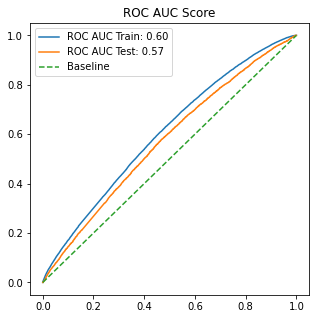

0.2749200557157711 0.2712861963430903
Wall time: 2min 10s


In [25]:
%%time
pipline_response_testing = utils.pipeline(
                features_df            =merged_features_df.copy(), ## grouped_features_df ## session_df
                train_df               =train_df, ##pd.concat([train_df, val_df])
                val_df                 =val_df,
                left_on                ='CLIENT_ID', right_on='CLIENT_ID',
                tech_cols              =['CLIENT_ID'], target_column='TARGET',
                drop_singular_cut_off  =0.9,
                drop_corr_cut_off      =0.75,
                n_trials               =50,
                model_filename         ='model_friends.txt'
            )

CUTTING features_df
Длина DataFrame после drop_singular(features_df, 0.9): 3
Длина DataFrame после drop_corr(features_df, ['CLIENT_ID'], 0.75): 3
MERGING into train and validations dataframes
ASE level


[I 2022-09-25 01:37:14,288] A new study created in memory with name: no-name-cf216961-b599-4c8f-a482-18b32954a64a


roc_auc_score для LGBMClassifier: 0.6693542798758769
SEARCH for best params


[I 2022-09-25 01:37:14,811] Trial 0 finished with value: 0.6521310108417304 and parameters: {'n_estimators': 75, 'max_depth': 6, 'learning_rate': 0.06559331471412151, 'colsample_bytree': 0.9085805099922601, 'subsample': 0.4048692330882489, 'reg_lambda': 0.7221206756931633, 'num_leaves': 148, 'scale_pos_weight': 2.0574484916123175}. Best is trial 0 with value: 0.6521310108417304.
[I 2022-09-25 01:37:15,304] Trial 1 finished with value: 0.7479822876681118 and parameters: {'n_estimators': 93, 'max_depth': 6, 'learning_rate': 0.29232884437031154, 'colsample_bytree': 0.5982895559253631, 'subsample': 0.6283931437130952, 'reg_lambda': 0.6522265053027452, 'num_leaves': 96, 'scale_pos_weight': 1.7170956033174773}. Best is trial 1 with value: 0.7479822876681118.
[I 2022-09-25 01:37:15,562] Trial 2 finished with value: 0.5859891634406176 and parameters: {'n_estimators': 24, 'max_depth': 3, 'learning_rate': 0.19506629266557513, 'colsample_bytree': 0.6176252223096717, 'subsample': 0.879934125424402

[I 2022-09-25 01:37:24,042] Trial 21 finished with value: 0.7933152033496541 and parameters: {'n_estimators': 48, 'max_depth': 8, 'learning_rate': 0.48701639292133125, 'colsample_bytree': 0.724400891862814, 'subsample': 0.7960182234176092, 'reg_lambda': 0.3057753908585031, 'num_leaves': 117, 'scale_pos_weight': 1.5929540868255545}. Best is trial 9 with value: 0.841898094686693.
[I 2022-09-25 01:37:24,403] Trial 22 finished with value: 0.7075029308414862 and parameters: {'n_estimators': 34, 'max_depth': 7, 'learning_rate': 0.38946764367110315, 'colsample_bytree': 0.7878319351420678, 'subsample': 0.7336187071155011, 'reg_lambda': 0.16311253619422134, 'num_leaves': 80, 'scale_pos_weight': 1.3505802769475435}. Best is trial 9 with value: 0.841898094686693.
[I 2022-09-25 01:37:24,900] Trial 23 finished with value: 0.8389021008917223 and parameters: {'n_estimators': 58, 'max_depth': 8, 'learning_rate': 0.43586171510889365, 'colsample_bytree': 0.6740967821966056, 'subsample': 0.70895652966281

[I 2022-09-25 01:37:36,791] Trial 42 finished with value: 0.8932198672830494 and parameters: {'n_estimators': 100, 'max_depth': 8, 'learning_rate': 0.4678336089585976, 'colsample_bytree': 0.4698015475637629, 'subsample': 0.48959047501328523, 'reg_lambda': 0.7783867150654129, 'num_leaves': 181, 'scale_pos_weight': 2.249201310377447}. Best is trial 27 with value: 0.9017511711684321.
[I 2022-09-25 01:37:37,541] Trial 43 finished with value: 0.8985876862541431 and parameters: {'n_estimators': 100, 'max_depth': 8, 'learning_rate': 0.44985066706871246, 'colsample_bytree': 0.4839368431800518, 'subsample': 0.5991103068167154, 'reg_lambda': 0.7661148408473122, 'num_leaves': 179, 'scale_pos_weight': 2.40549767366507}. Best is trial 27 with value: 0.9017511711684321.
[I 2022-09-25 01:37:38,304] Trial 44 finished with value: 0.8906640565350709 and parameters: {'n_estimators': 94, 'max_depth': 8, 'learning_rate': 0.4440198962684131, 'colsample_bytree': 0.5080060348428401, 'subsample': 0.59410933515

--------------------
Best params:
{'n_estimators': 100, 'max_depth': 8, 'learning_rate': 0.4472318709911177, 'colsample_bytree': 0.5104591486189352, 'subsample': 0.5233558401026379, 'reg_lambda': 0.6836323420768358, 'num_leaves': 235, 'scale_pos_weight': 2.147564204679716}


len(argList): 18
argList: ['u0=106', 'i3192', 'u0=101', 'i739', 'i646', 'i536', 'i692', 'i4372', 'u1=187', 'i3318', 'i4382', 'i788', 'i3654', 'i720', 'i3298', 'i606', 'i876', 'i645']


ROC AUC Test initial = 0.666707457598354
Осталось фичей: 17, ROC AUC = 0.6696408924050194, удалена фича u0=106
Осталось фичей: 16, ROC AUC = 0.6666488742559507, удалена фича i606
Осталось фичей: 15, ROC AUC = 0.6666684409754972, удалена фича i3654
Осталось фичей: 14, ROC AUC = 0.6647614003456889, удалена фича i876
Осталось фичей: 13, ROC AUC = 0.6641816997740494, удалена фича i720


[I 2022-09-25 01:38:51,521] A new study created in memory with name: no-name-5de08a2d-84cb-45eb-b737-f6333888a482


len(argList2): 13
argList2: ['i3192', 'u0=101', 'i739', 'i646', 'i536', 'i692', 'i4372', 'u1=187', 'i3318', 'i4382', 'i788', 'i3298', 'i645']


[I 2022-09-25 01:38:51,744] Trial 0 finished with value: 0.6089485068424099 and parameters: {'n_estimators': 78, 'max_depth': 3, 'learning_rate': 0.43852980487048143, 'colsample_bytree': 0.8756788111186428, 'subsample': 0.818525826504984, 'reg_lambda': 0.8214744946295731, 'num_leaves': 209, 'scale_pos_weight': 2.4088751960086707}. Best is trial 0 with value: 0.6089485068424099.
[I 2022-09-25 01:38:51,964] Trial 1 finished with value: 0.6004046062729009 and parameters: {'n_estimators': 87, 'max_depth': 3, 'learning_rate': 0.24231816082067975, 'colsample_bytree': 0.5178971309530691, 'subsample': 0.9605412368916515, 'reg_lambda': 0.2634622488034316, 'num_leaves': 207, 'scale_pos_weight': 1.7422840163844369}. Best is trial 0 with value: 0.6089485068424099.
[I 2022-09-25 01:38:52,152] Trial 2 finished with value: 0.6163852659587955 and parameters: {'n_estimators': 31, 'max_depth': 5, 'learning_rate': 0.2251909782156692, 'colsample_bytree': 0.6582120468836196, 'subsample': 0.8091490967263938

[I 2022-09-25 01:38:57,186] Trial 21 finished with value: 0.731558251958105 and parameters: {'n_estimators': 42, 'max_depth': 7, 'learning_rate': 0.3929107348222875, 'colsample_bytree': 0.9519689334539931, 'subsample': 0.5809945100331374, 'reg_lambda': 0.15809047410263977, 'num_leaves': 96, 'scale_pos_weight': 1.5980555006593191}. Best is trial 20 with value: 0.7383053513798116.
[I 2022-09-25 01:38:57,450] Trial 22 finished with value: 0.7490668212856751 and parameters: {'n_estimators': 40, 'max_depth': 8, 'learning_rate': 0.38773317892932574, 'colsample_bytree': 0.9065065535788707, 'subsample': 0.6004502685948208, 'reg_lambda': 0.131471608322194, 'num_leaves': 103, 'scale_pos_weight': 1.5793233053103142}. Best is trial 22 with value: 0.7490668212856751.
[I 2022-09-25 01:38:57,663] Trial 23 finished with value: 0.6920963489724002 and parameters: {'n_estimators': 22, 'max_depth': 8, 'learning_rate': 0.39386610611552325, 'colsample_bytree': 0.8907400687360689, 'subsample': 0.594952558300

[I 2022-09-25 01:39:03,926] Trial 42 finished with value: 0.8628721500498633 and parameters: {'n_estimators': 86, 'max_depth': 8, 'learning_rate': 0.46950393314690325, 'colsample_bytree': 0.48430768137827107, 'subsample': 0.6971197949935413, 'reg_lambda': 0.41386646265165394, 'num_leaves': 161, 'scale_pos_weight': 1.9419016618916298}. Best is trial 37 with value: 0.87445942118583.
[I 2022-09-25 01:39:04,349] Trial 43 finished with value: 0.8624316165541629 and parameters: {'n_estimators': 86, 'max_depth': 8, 'learning_rate': 0.4777524356194625, 'colsample_bytree': 0.4913514907261952, 'subsample': 0.6888356285443611, 'reg_lambda': 0.4077763977786565, 'num_leaves': 191, 'scale_pos_weight': 1.956705310523748}. Best is trial 37 with value: 0.87445942118583.
[I 2022-09-25 01:39:04,787] Trial 44 finished with value: 0.8611090387045521 and parameters: {'n_estimators': 90, 'max_depth': 8, 'learning_rate': 0.45053735253843774, 'colsample_bytree': 0.42411295883957384, 'subsample': 0.729481950764

Training a model


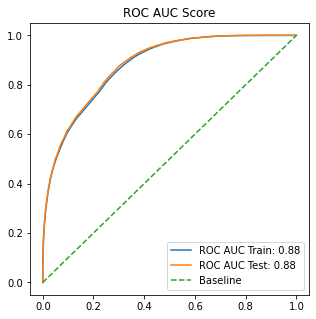

0.2741932952476615 0.2712861963430903
Wall time: 1min 54s


In [26]:
%%time
pipline_response = utils.pipeline(
                features_df            =merged_features_df.copy(), ## grouped_features_df ## session_df
                train_df               =pd.concat([train_df, val_df]), ##
                val_df                 =val_df,
                left_on                ='CLIENT_ID', right_on='CLIENT_ID',
                tech_cols              =['CLIENT_ID'], target_column='TARGET',
                drop_singular_cut_off  =0.9,
                drop_corr_cut_off      =0.75,
                n_trials               =50,
                model_filename         ='model_friends.txt'
            )

In [27]:
print(pipline_response['argList2'])

['i3192', 'u0=101', 'i739', 'i646', 'i536', 'i692', 'i4372', 'u1=187', 'i3318', 'i4382', 'i788', 'i3298', 'i645']


# Название для submission

In [28]:
submission_name = 'all_features_log'

# Результаты модели на тестовой части неразмеченных данных
#### Сохрание файла для submission

In [30]:
test_features_df = test_df.merge(merged_features_df, how='left', on='CLIENT_ID')
test_features_df = test_features_df.dropna()
test_features_df = test_features_df.drop('TARGET', axis=1)
test_features_df.head()

,CLIENT_ID,FRIEND_ID,i3192,i3274,i3284,i3298,i3318,i3356,i3654,i4372,...,i876,u0=101,u0=106,u0=151,u0=153,u1=161,u1=169,u1=175,u1=187,u1=190
0,1025140,1.000000,0.000000,0.001525,0.000963,0.002090,0.000013,0.000083,0.000120,0.000014,...,0.000693,0.000005,0.000007,0.0,0.0,0.0,0.000000,0.0,0.001160,0.000000
1,1029732,1.000000,0.000021,0.000182,0.000079,0.000192,0.000037,0.000405,0.000359,0.000007,...,0.000343,0.000035,0.000006,0.0,0.0,0.0,0.000005,0.0,0.000346,0.000002
2,1079794,0.330000,0.000000,0.001984,0.000743,0.000102,0.000019,0.000872,0.000207,0.000008,...,0.001453,0.000251,0.010340,0.0,0.0,0.0,0.000000,0.0,0.000321,0.000000
3,1116331,0.763956,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000008,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
4,1136822,1.000000,0.000041,0.000432,0.000265,0.000869,0.000061,0.000284,0.000735,0.000005,...,0.000855,0.000087,0.000006,0.0,0.0,0.0,0.000000,0.0,0.000153,0.000000


In [31]:
example_feature = list(test_features_df.columns.difference(['CLIENT_ID', 'TARGET', 'FRIEND_ID', 'test']))[0]

test_features_df = test_df.merge(merged_features_df, how='left', on='CLIENT_ID')
unmapped_clients = list(test_features_df[test_features_df[example_feature].isna()]['CLIENT_ID'])
test_features_cleared_df = test_features_df.dropna()
test_features_cleared_df = test_features_cleared_df.drop('TARGET', axis=1)
test_features_cleared_df.head(5)

,CLIENT_ID,FRIEND_ID,i3192,i3274,i3284,i3298,i3318,i3356,i3654,i4372,...,i876,u0=101,u0=106,u0=151,u0=153,u1=161,u1=169,u1=175,u1=187,u1=190
0,1025140,1.000000,0.000000,0.001525,0.000963,0.002090,0.000013,0.000083,0.000120,0.000014,...,0.000693,0.000005,0.000007,0.0,0.0,0.0,0.000000,0.0,0.001160,0.000000
1,1029732,1.000000,0.000021,0.000182,0.000079,0.000192,0.000037,0.000405,0.000359,0.000007,...,0.000343,0.000035,0.000006,0.0,0.0,0.0,0.000005,0.0,0.000346,0.000002
2,1079794,0.330000,0.000000,0.001984,0.000743,0.000102,0.000019,0.000872,0.000207,0.000008,...,0.001453,0.000251,0.010340,0.0,0.0,0.0,0.000000,0.0,0.000321,0.000000
3,1116331,0.763956,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000008,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
4,1136822,1.000000,0.000041,0.000432,0.000265,0.000869,0.000061,0.000284,0.000735,0.000005,...,0.000855,0.000087,0.000006,0.0,0.0,0.0,0.000000,0.0,0.000153,0.000000


In [32]:
probs = pipline_response['model'].predict_proba(test_features_cleared_df[pipline_response['argList2']])[:, 1]

In [33]:
submition_df = pd.DataFrame(
    {
#         'CLIENT_ID': full_features_df['CLIENT_ID'],
        'CLIENT_ID': test_features_cleared_df['CLIENT_ID'],
        'TARGET': probs
    }
)

In [35]:
print(len(submition_df))
submition_df.head(5)

31858


,CLIENT_ID,TARGET
0,1025140,0.504399
1,1029732,0.230290
2,1079794,0.358990
3,1116331,0.483967
4,1136822,0.224029


In [36]:
fullfilled_train_val_df =pd.DataFrame(
    {
#         'CLIENT_ID': list(pd.concat([train_df, val_df])['CLIENT_ID']),
        'CLIENT_ID': list(test_df['CLIENT_ID']),
        'TARGET': submition_df['TARGET'].mean()
    }
)

In [37]:
submition_df = pd.concat(
    [
        submition_df,
        fullfilled_train_val_df[~fullfilled_train_val_df['CLIENT_ID'].isin(submition_df['CLIENT_ID'])]
    ]
)

<AxesSubplot:>

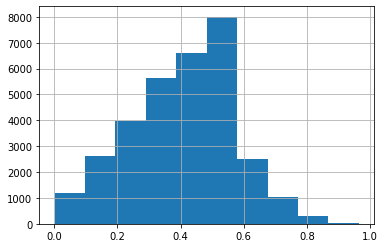

In [38]:
submition_df['TARGET'].hist()

In [39]:
submition_df.head(1)

,CLIENT_ID,TARGET
0,1025140,0.504399


In [40]:
submition_df.to_csv(f'./data/submissions/test_{submission_name}_submition.csv', decimal='.', sep=',', index=False)

# Результаты модели на траин части размеченных данных

In [41]:
full_features_df = pd.concat([train_df, val_df]).merge(merged_features_df, how='left', on='CLIENT_ID')
full_features_df = full_features_df.dropna()
full_features_df = full_features_df.drop('TARGET', axis=1)
full_features_df.head()

,CLIENT_ID,FRIEND_ID,i3192,i3274,i3284,i3298,i3318,i3356,i3654,i4372,...,i876,u0=101,u0=106,u0=151,u0=153,u1=161,u1=169,u1=175,u1=187,u1=190
0,1580286,1.00,0.000143,0.001788,0.000826,0.001786,0.000080,0.000189,0.001064,0.000147,...,0.001188,0.000009,0.000033,0.0,0.0,0.000000e+00,0.000000e+00,0.000007,0.000045,0.0
1,68513,1.00,0.000017,0.001274,0.000025,0.000054,0.000044,0.000140,0.001726,0.000049,...,0.002164,0.000074,0.000002,0.0,0.0,0.000000e+00,4.695542e-06,0.000002,0.010948,0.0
2,1579276,0.90,0.000043,0.007898,0.001719,0.003634,0.000084,0.000683,0.006376,0.001701,...,0.005331,0.000195,0.000000,0.0,0.0,0.000000e+00,0.000000e+00,0.000000,0.000970,0.0
3,1531035,1.00,0.000008,0.000153,0.000053,0.000095,0.000054,0.000107,0.000085,0.000006,...,0.000232,0.000127,0.000002,0.0,0.0,6.342159e-08,1.657254e-07,0.000224,0.000084,0.0
4,1547532,0.61,0.000029,0.000454,0.000186,0.000121,0.000128,0.000094,0.000301,0.000132,...,0.000566,0.000277,0.000000,0.0,0.0,0.000000e+00,0.000000e+00,0.000000,0.000342,0.0


In [42]:
probs = pipline_response['model'].predict_proba(full_features_df[pipline_response['argList2']])[:, 1]

In [43]:
submition_df = pd.DataFrame(
    {
        'CLIENT_ID': full_features_df['CLIENT_ID'],
#         'CLIENT_ID': test_features_cleared_df['CLIENT_ID'],
        'TARGET': probs
    }
)

In [44]:
fullfilled_train_val_df =pd.DataFrame(
    {
        'CLIENT_ID': list(pd.concat([train_df, val_df])['CLIENT_ID']),
#         'CLIENT_ID': list(test_df['CLIENT_ID']),
        'TARGET': submition_df['TARGET'].mean()
    }
)

In [45]:
submition_df = pd.concat(
    [
        submition_df,
        fullfilled_train_val_df[~fullfilled_train_val_df['CLIENT_ID'].isin(submition_df['CLIENT_ID'])]
    ]
)

<AxesSubplot:>

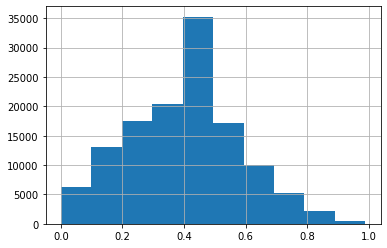

In [46]:
submition_df['TARGET'].hist()

In [47]:
submition_df.head(1)

,CLIENT_ID,TARGET
0,1580286,0.24922


In [48]:
submition_df.to_csv(f'./data/submissions/train_{submission_name}_submition.csv', decimal='.', sep=',', index=False)

## HIST of sessions

In [428]:
# seq_matrix_df = pd.read_csv('./data/FINAL_SEQUENCES_MATRIX.tsv', 
#                          sep=";")
# seq_matrix = seq_matrix_df.SESSIONS_SEQUENCES.apply(eval)a

In [63]:
all_seq_matrix_df = pd.read_csv('./data/FINAL_ALL_SEQUENCES_TRAINTEST.tsv',
                         sep="\t")
all_seq_matrix = all_seq_matrix_df.SEQUENCE.apply(eval)
all_seq_matrix_df['SEQUENCE'] = all_seq_matrix

In [76]:
all_seq_matrix_df.SEQUENCE

0         [e84b0f471b8e8f4aecc81eb27b16c092, 9a7670be67a...
1         [9804a8d70c5e8c26830bdafe2c2db49c, 9ca02fb0f61...
2         [b496d19eb25556bd64e481d11b6f7dd6, eb727f97274...
3         [467a38fe36ef666e264823387f66f3c8, e0494409283...
4         [b496d19eb25556bd64e481d11b6f7dd6, fc18cab3702...
                                ...                        
123702    [c734cde7f7ab57d48debbd587f4cf126, fdc759e271e...
123703    [1669b50f343dd2e888c2ef6e2a218b23, 27317357d76...
123704    [5f82488fb41f39bb377b55eb85837dba, 6d69d0393c5...
123705    [6a59be6dae2918aa5a0d79ac0cbc39ef, dcfd13a9db6...
123706    [44ecadc8f152cae87366305bbbaf6215, 605fe140d2b...
Name: SEQUENCE, Length: 123707, dtype: object

In [77]:
all_seq_df = all_seq_matrix_df.merge(pd.concat([train_df, val_df]), how='left', on='CLIENT_ID').dropna()

In [78]:
all_seq_df_0 = all_seq_df[all_seq_df['TARGET'] == 0]
all_seq_df_1 = all_seq_df[all_seq_df['TARGET'] == 1]

In [79]:
def code_to_dict(seq_matrix):
    dict_int = dict()
    for seq in tqdm_notebook(seq_matrix.to_list()):
        for code in seq:
            if code not in dict_int.keys():
                dict_int[code] = 1
            else:
                dict_int[code] += 1
    return dict_int

In [80]:
all_seq_0_dict = code_to_dict(seq_matrix=all_seq_df_0['SEQUENCE'])
all_seq_1_dict = code_to_dict(seq_matrix=all_seq_df_1['SEQUENCE'])

  0%|          | 0/72085 [00:00<?, ?it/s]

  0%|          | 0/26858 [00:00<?, ?it/s]

In [480]:
all_seq_0_data = [(k, v) for k, v in all_seq_0_dict.items()]
all_seq_1_data = [(k, v) for k, v in all_seq_1_dict.items()]

all_seq_0_data = sorted(all_seq_0_data, key=lambda x: x[1])[::-1]
all_seq_1_data = sorted(all_seq_1_data, key=lambda x: x[1])[::-1]

In [500]:
# for a,b in zip(list(map(lambda x: x[0], all_seq_0_data[:N])), list(map(lambda x: x[0], all_seq_1_data[:N]))):
#     print(a == b)
#     print(a,b)

<BarContainer object of 30 artists>

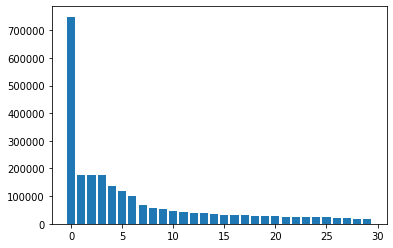

In [481]:
N = 30
plt.bar(list(range(len(all_seq_1_data[:N]))), list(map(lambda x: x[1], all_seq_1_data[:N])))

<BarContainer object of 30 artists>

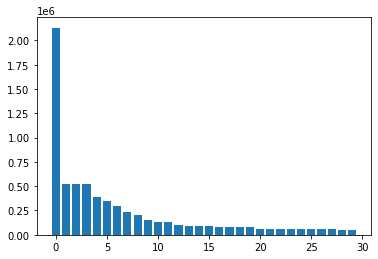

In [482]:
N = 30
plt.bar(list(range(len(all_seq_0_data[:N]))), list(map(lambda x: x[1], all_seq_0_data[:N])))